In [1]:
import sys
import os
sys.path.insert(0, os.getcwd()+"/Utils")
sys.path.insert(0, os.getcwd()+"/Models")
import numpy as np
import random
import matplotlib.pyplot as plt
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from skimage.color import label2rgb

Using TensorFlow backend.


In [2]:
import unet2dstatic
import generate_mask_files
import augmentation_generator

In [3]:
from imp import reload
reload(generate_mask_files)
reload(augmentation_generator)
reload(unet2dstatic)

<module 'unet2dstatic' from 'C:\\users\\aduen\\Projects\\Image_Seg\\ImageSegmentation/Models\\unet2dstatic.py'>

In [4]:
Color_Dict = {
    'background': np.array([0, 0, 0, 0]),
    'goblet': np.array([255,127,14, 255]),
    'microvilli': np.array([31,110,180,255]),
    'nucleus': np.array([44, 160, 44, 255]),
    'basement': np.array([214, 39, 40, 255])   
}

category_labels = ['nucleus']
#category_labels = ['background','nucleus', 'microvilli','goblet','basement']

model_inputs = {
      "image_height": 256,
      "image_width": 256,
      "input_channels": 1,
      "categories": len(category_labels),
      "category_labels": category_labels,
      "mask_color_dict": Color_Dict,
      "validation_split": 0.1,
      "epochs": 5,
      "batch_size": 5,
      "filename": os.path.join(os.getcwd(),'Unet2D-multicat-trained.h5'),
      "stop_after": 10,
      "image_count": 1000,
      "image_directory": os.path.join(os.getcwd(), 'Training', 'Approved_Raw_Images'),
      "mask_directory":  os.path.join(os.getcwd(), 'Training', 'Approved'),
      "training_directory": os.path.join(os.getcwd(), 'Training', 'Masks'),
      "test_split": 0.2
    }

if len(category_labels)==1:
    model_inputs['filename'] = os.path.join(os.getcwd(),'Unet2D-singlecat-trained.h5')


In [6]:
model_outputs={}
model_outputs['generated_mask_files'] = generate_mask_files.create_masks(model_inputs)


Directory  C:\users\aduen\Projects\Image_Seg\ImageSegmentation\Training\Masks\nucleus  Created 
Created 129 mask files in C:\users\aduen\Projects\Image_Seg\ImageSegmentation\Training\Masks


In [7]:
p = augmentation_generator.get_pipeline(model_inputs)

using 129 images
with 1 mask categories


In [8]:
g = p.generator(batch_size=10)

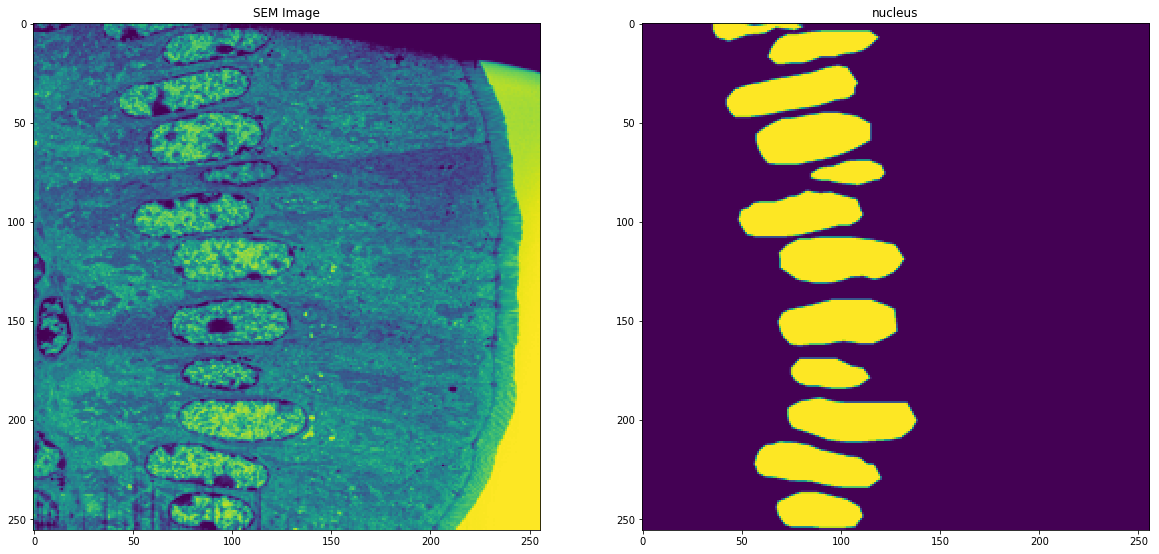

In [9]:
augmented_images = next(g)
categories = model_inputs['category_labels']
r_index = random.randint(0, len(augmented_images)-1)
f, axarr = plt.subplots(1, len(categories)+1, figsize=(20,15))
axarr[0].imshow(augmented_images[r_index][0])
axarr[0].set_title('SEM Image')               
for idx,category in enumerate(categories):
    axarr[idx+1].imshow(augmented_images[r_index][idx+1])
    axarr[idx+1].set_title(category)

In [10]:
from augmentation_generator import multi_generator, single_generator

if model_inputs['categories'] ==1:
    g  = single_generator(p,model_inputs['batch_size'])
    gv = single_generator(p,model_inputs['batch_size'])
else:
    #Training pipeline
    g = multi_generator(p,model_inputs['batch_size'])
    #Training validation pipeline
    gv = multi_generator(p,model_inputs['batch_size'])


## Load Model

In [11]:
import unet2dstatic
earlystopper = EarlyStopping(patience=model_inputs['stop_after'], verbose=0)
checkpointer = ModelCheckpoint(model_inputs['filename'], verbose=1, save_best_only=True)
callback_list = [earlystopper, checkpointer]

if not os.path.isfile(model_inputs['filename']):
    categories         = model_inputs['categories']
    
    input_size         = (model_inputs['image_height'],
                          model_inputs['image_width'],
                          model_inputs['input_channels'])
    
    model = unet2dstatic.unet(pretrained_weights = None, input_size = input_size, channels = categories)

else:
    if model_inputs['categories']==1:
        custom_obj = { 'dice_coef_loss': unet2dstatic.dice_coef_loss, 'dice_coef': unet2dstatic.dice_coef }
        model =  load_model(model_inputs['filename'], custom_objects=custom_obj)
    else:     
        model = load_model(model_inputs['filename'])
    

C:\users\aduen\Projects\Image_Seg\ImageSegmentation/Models\unet2dstatic.py:67: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = activation)


## Train Model

In [12]:
# model = load_model(model_inputs['filename'], custom_objects={ 'dice_coef_loss': unet2dstaticSingle.dice_coef_loss, 'dice_coef': unet2dstaticSingle.dice_coef })
results = model.fit_generator(generator        = g,
                              validation_data  = gv, 
                              steps_per_epoch  = model_inputs['image_count'],
                              validation_steps = int(model_inputs['image_count']*model_inputs['validation_split']),
                              epochs           = model_inputs['epochs'],
                              callbacks=callback_list)

Epoch 1/5
   5/1000 [..............................] - ETA: 55:28 - loss: 0.5614 - dice_coef: 0.1694  

KeyboardInterrupt: 

## Visualize Results

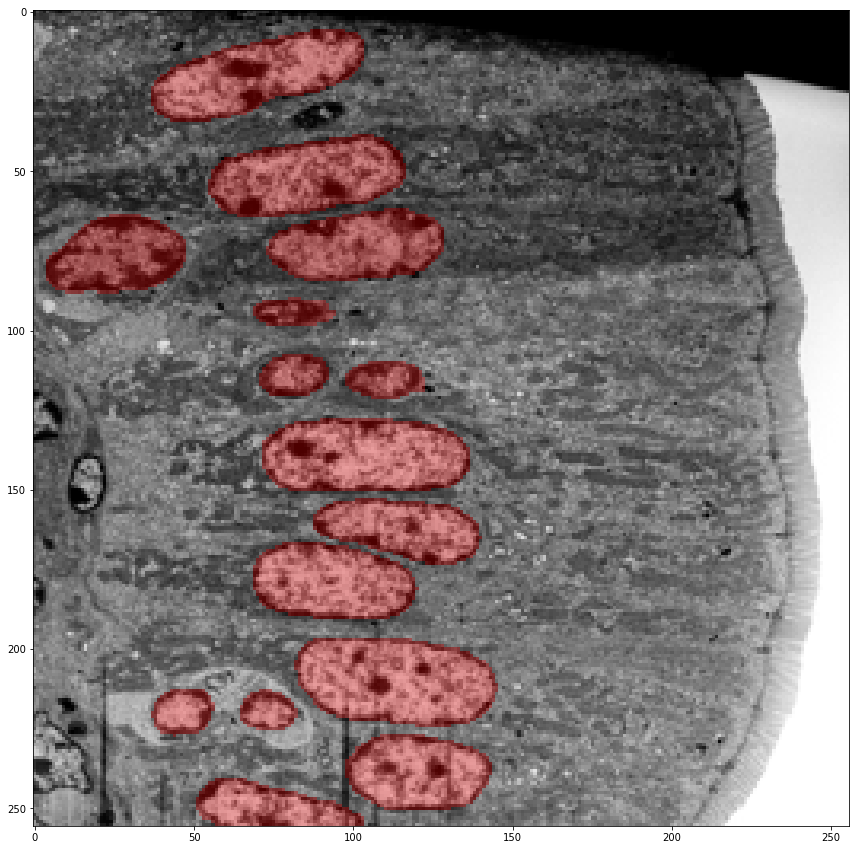

In [24]:
augmented_images = np.asarray(p.sample(2)[0][0])

f, axarr = plt.subplots(1, 1, figsize=(20,15))
if model_inputs['categories']==1:
    custom_obj = { 'dice_coef_loss': unet2dstatic.dice_coef_loss, 'dice_coef': unet2dstatic.dice_coef }
    best_model =  load_model(model_inputs['filename'], custom_objects=custom_obj)
else:     
    best_model = load_model(model_inputs['filename'])

predict = best_model.predict(np.expand_dims(np.expand_dims(augmented_images,0),-1))
predict = predict.reshape(256,256,model_inputs['categories'])*255//1

threshold = 10
if model_inputs['categories']==1:
    nucleus =  np.greater(predict[:,:,0],np.min(predict[:,:,0])*threshold)*1
    mask = (nucleus).astype('uint8')
    mask_layer = label2rgb(mask, image=augmented_images, colors=None, alpha=0.3, bg_label=0, bg_color=None, image_alpha=1)
    plt.imshow(mask_layer)
else:
    nucleus =  np.greater(predict[:,:,1],np.min(predict[:,:,1])*threshold)*1
    microvilli =  np.greater(predict[:,:,2],np.min(predict[:,:,2])*threshold)*2
    goblet =  np.greater(predict[:,:,3],np.min(predict[:,:,3])*threshold)*3
    basement =  np.greater(predict[:,:,4],np.min(predict[:,:,4])*threshold)*4
    mask = (nucleus+microvilli+goblet+basement).astype('uint8')
    mask_layer = label2rgb(mask, image=augmented_images, colors=None, alpha=0.3, bg_label=0, bg_color=None, image_alpha=1)
    plt.imshow(mask_layer)

## Cleanup

In [25]:
model_outputs['generated_mask_files'] = generate_mask_files.cleanup_masks(model_outputs['generated_mask_files'])